# Sebastian Garcia
# Text Preprocessing and Topic modeling (English)
 

In [2]:
import pandas as pd
import numpy as np
import gensim.corpora as corpora
import matplotlib.pyplot as plt
import re
import gensim
import warnings
import nltk
import spacy
import pyLDAvis
import pyLDAvis.gensim
from pprint import pprint
from nltk.corpus import stopwords
from langdetect import detect_langs
from langdetect import DetectorFactory
from gensim.models.coherencemodel import CoherenceModel


### Data Wrangling


In [4]:
df = pd.read_csv('job_ads_eng.csv')


In [6]:
df.head()


,Keywords,Job title,Date published,Alive until,Company name,Location,Company type,Contract type,Occupation,Job rank,Content,Industry,Official website,Canton initials,Canton name
0,ICT System Engineer,System Engineer,2019-05-27 00:00:00,2019-06-05 00:00:00,Harvey Nash AG,Zürich,Consultants,Unlimited employment,100,Employee,System EngineerJob Description Overview of b...,"Recruitment agency, Staffing",http://www.harveynash.com/ch,ZH,Zurich
1,Automation Engineer,Automation Engineer with DeltaV,2019-04-23 00:00:00,2019-05-03 00:00:00,Spring Professional Engineering,Sion,Consultants,Unlimited employment,100,Position with responsibilities,Ihre Herausforderung You plan and implement A...,"Recruitment agency, Staffing",https://www.springprofessional.ch/,VS,Valais
2,Development Engineer,Junior Development Engineer 100% (m/f/d),2019-05-08 00:00:00,2019-05-24 00:00:00,Zentra AG Ihr Jobprofi,Canton of Zug,Consultants,Unlimited employment,Temporary,Position with responsibilities,Since 1989 - more than a quarter of a centur...,"Recruitment agency, Staffing",http://www.zentra.ch,ZG,Zug
3,Contract Analyst,Contract & Commercial Manager,2019-06-14 00:00:00,2019-06-24 00:00:00,Huawei Technologies Switzerland AG,Dübendorf ZH,Large-scale entreprises,Unlimited employment,100,Position with responsibilities,Huawei is a leading global provider of informa...,"Information technology, Telecom.",http://www.huawei.com/,ZH,Zurich
4,Executive Assistant,Executive Assistant 100 %,2019-06-19 00:00:00,2019-06-24 00:00:00,Habasit AG,Reinach,Small and medium-sized enterprises,Unlimited employment,100,Employee,Executive Assistant 100 %Habasit is an interna...,Industry various,http://www.habasit.com,BL,Basel


In [7]:
# Convert column to list
text_corpus = df['Job title'].values.tolist()
text_corpus[0]


'System Engineer'

In [8]:
# Noise removal
text_corpus = [re.sub(r'\s', ' ', str(text)) for text in text_corpus] # Replace wspace by ' '
text_corpus = [re.sub('\s+', ' ', doc) for doc in text_corpus] # Remove newline characters
text_corpus = [re.sub("\'", "", doc) for doc in text_corpus] # Remove single quote 
text_corpus = [re.sub(r'\b\w{1,3}\b', '', doc) for doc in text_corpus] # Remove words < 3 letters
text_corpus[0]


<>:3: DeprecationWarning: invalid escape sequence \s
<>:3: DeprecationWarning: invalid escape sequence \s
<>:3: DeprecationWarning: invalid escape sequence \s
<ipython-input-8-6c8464b7bf9d>:3: DeprecationWarning: invalid escape sequence \s
  text_corpus = [re.sub('\s+', ' ', doc) for doc in text_corpus] # Remove newline characters


'System Engineer'

In [11]:
# Tokenize words
warnings.simplefilter("ignore", DeprecationWarning)
 
def doc_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

words = list(doc_to_words(text_corpus_germ))
 
print(words[:5])


[['automation', 'engineer', 'with', 'deltav'], ['junior', 'development', 'engineer'], ['contract', 'commercial', 'manager'], ['test', 'manager', 'banking', 'financial', 'services'], ['communications', 'officer']]


### Lexicon Normalization

In [13]:
# Remove stopwords
stop_words = stopwords.words('english')

# Add additional options
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
 
def remove_stopwords(text):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in text_corpus_germ]
 
# Apply the function for removing stopwords
words = remove_stopwords(words)
 
print(words[:5])


[['automation', 'engineer', 'deltav'], ['junior', 'development', 'engineer'], ['contract', 'commercial', 'manager'], ['test', 'manager', 'banking', 'financial', 'services'], ['communications', 'officer']]


In [14]:
# Lemmatization
nlp = spacy.load('de_core_news_sm', disable=['parser', 'ner'])
 
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for idx, sent in enumerate(texts):
        if (idx) % 500 == 0:
            print(str(idx) + ' documents lemmatised')
        doc = nlp(" ".join(sent)) # Join all words and apply lemmatization function
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags]) # Iterate
    return texts_out
 
data_lemmatized = lemmatization(words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


0 documents lemmatised
500 documents lemmatised
1000 documents lemmatised
1500 documents lemmatised
2000 documents lemmatised
2500 documents lemmatised
3000 documents lemmatised
3500 documents lemmatised
4000 documents lemmatised
4500 documents lemmatised
5000 documents lemmatised
5500 documents lemmatised
6000 documents lemmatised
6500 documents lemmatised
7000 documents lemmatised
7500 documents lemmatised


In [15]:
print(data_lemmatized[0])


['automation', 'engineer', 'deltav']


### Topic Modeling: LDA

In [16]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
 
# Create Corpus
corpus = [id2word.doc2bow(text) for text in words]
corpus[0]


[(0, 1), (1, 1), (2, 1)]

In [17]:
# Format Corpus
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]


[[('automation', 1), ('deltav', 1), ('engineer', 1)]]

In [34]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=31, 
                                           per_word_topics=True)

# To play with:

# corpus=corpus, id2word=id2word, num_topics=20, random_state=100, 
# update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True

In [35]:
# Print the keywords and its weight
pprint(lda_model.print_topics(num_words=10))


[(17,
  '0.146*"student" + 0.102*"position" + 0.069*"development" + '
  '0.038*"documentation" + 0.037*"basel" + 0.027*"learning" + 0.024*"medical" '
  '+ 0.024*"specialist" + 0.023*"vision" + 0.023*"machine"'),
 (14,
  '0.196*"assistant" + 0.140*"manager" + 0.075*"account" + 0.068*"executive" + '
  '0.047*"senior" + 0.030*"insurance" + 0.021*"avaloq" + 0.020*"functional" + '
  '0.013*"structural" + 0.012*"life"'),
 (3,
  '0.133*"expert" + 0.066*"technology" + 0.043*"management" + 0.036*"services" '
  '+ 0.035*"support" + 0.034*"head" + 0.032*"manager" + 0.031*"data" + '
  '0.022*"supply" + 0.021*"director"'),
 (24,
  '0.143*"research" + 0.126*"associate" + 0.043*"part" + 0.038*"time" + '
  '0.035*"controller" + 0.032*"experience" + 0.026*"supply" + 0.025*"manager" '
  '+ 0.025*"investment" + 0.024*"planner"'),
 (5,
  '0.091*"sales" + 0.063*"researcher" + 0.061*"director" + '
  '0.058*"postdoctoral" + 0.049*"scientific" + 0.038*"assistant" + '
  '0.033*"europe" + 0.033*"medical" + 0.03

### Tuning

In [28]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values


In [31]:
# Find optimal number of topics
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, texts=words, 
                                                        start=25, limit=35, step=3)


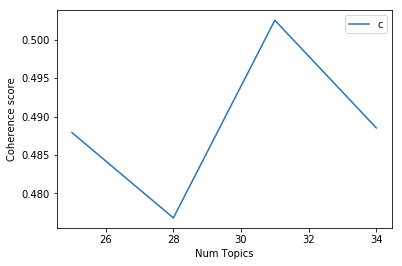

In [33]:
# Show graph
limit=35; start=25; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


### Benchmarking

In [36]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))



Perplexity:  -7.971577567338034


In [37]:
# Compute Coherence Score
coherence_lda_model = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_lda_model.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Coherence Score:  0.6083269301312569


### Visualization

In [38]:
# Visualize
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis


/Users/acallil/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
18    -0.182636  0.203224       1        1  6.127476
13     0.281724  0.126075       2        1  5.878339
29    -0.037503 -0.074041       3        1  5.673752
26    -0.045230 -0.027110       4        1  5.606497
16     0.280322  0.130251       5        1  4.983153
21    -0.153262  0.099372       6        1  3.921361
14    -0.135968  0.119490       7        1  3.405250
5     -0.011986 -0.113281       8        1  3.395961
20    -0.038327  0.094332       9        1  3.265164
15    -0.062969 -0.074467      10        1  3.199161
28     0.019978 -0.240070      11        1  3.170377
19    -0.102323  0.015477      12        1  3.045175
1     -0.013231  0.021882      13        1  3.006236
4      0.034558 -0.186549      14        1  2.982962
0     -0.000297 -0.075219      15        1  2.912283
24     0.019447 -0.065081      16        1  2.909096
9     -0.105497  0.084883      17        1  2.878394
8     -0.067658  0.052550      18        1  2.692297
12     0.155787  0.102483      19        1  2.687333
3      0.001712 -0.048099      20        1  2.683503
11     0.086666 -0.067194      21        1  2.606983
10     0.183596  0.022138      22        1  2.605033
23     0.184592  0.061462      23        1  2.540715
2     -0.048088  0.067702      24        1  2.463482
17     0.022642 -0.126304      25        1  2.451972
7     -0.084097 -0.023067      26        1  2.437951
6     -0.053400 -0.051528      27        1  2.264155
22    -0.011222 -0.109062      28        1  2.229693
25    -0.057935  0.131307      29        1  2.221879
27    -0.041453  0.067639      30        1  1.879909
30    -0.017945 -0.119194      31        1  1.874461, topic_info=     Category         Freq          Term        Total  loglift  logprob
2     Default  1173.000000      engineer  1173.000000  30.0000  30.0000
7     Default  1788.000000       manager  1788.000000  29.0000  29.0000
8     Default   598.000000       analyst   598.000000  28.0000  28.0000
148   Default   361.000000    consultant   361.000000  27.0000  27.0000
38    Default   618.000000       project   618.000000  26.0000  26.0000
10    Default   462.000000    specialist   462.000000  25.0000  25.0000
30    Default   283.000000     assistant   283.000000  24.0000  24.0000
36    Default   258.000000       product   258.000000  23.0000  23.0000
29    Default   184.000000       digital   184.000000  22.0000  22.0000
1435  Default   441.000000      business   441.000000  21.0000  21.0000
12    Default   392.000000      software   392.000000  20.0000  20.0000
268   Default   179.000000     technical   179.000000  19.0000  19.0000
97    Default   252.000000     scientist   252.000000  18.0000  18.0000
362   Default   274.000000     developer   274.000000  17.0000  17.0000
37    Default   224.000000          head   224.000000  16.0000  16.0000
290   Default   143.000000    technician   143.000000  15.0000  15.0000
43    Default   177.000000      research   177.000000  14.0000  14.0000
289   Default   107.000000       student   107.000000  13.0000  13.0000
111   Default   195.000000        leader   195.000000  12.0000  12.0000
9     Default   365.000000          data   365.000000  11.0000  11.0000
11    Default  1026.000000        senior  1026.000000  10.0000  10.0000
39    Default   123.000000       affairs   123.000000   9.0000   9.0000
40    Default   126.000000    regulatory   126.000000   8.0000   8.0000
52    Default   325.000000    management   325.000000   7.0000   7.0000
54    Default   137.000000        expert   137.000000   6.0000   6.0000
60    Default   182.000000     associate   182.000000   5.0000   5.0000
294   Default   121.000000   engineering   121.000000   4.0000   4.0000
66    Default   203.000000         sales   203.000000   3.0000   3.0000
27    Default   169.000000     architect   169.000000   2.0000   2.0000
89    Default   159.000000          risk   159.0